<a href="https://colab.research.google.com/github/paolapt/8puzzle/blob/main/GenAlgv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
### FC 3: Genetic Algorithm in Python

import random
import matplotlib.pyplot as plt

# Problem Setup: System Model: A distributed system with 5 nodes, each with different capacities: (Node Constraints)
nodes = {
    1: {'cpu': 8, 'mem': 16, 'bw': 100},
    2: {'cpu': 4, 'mem': 32, 'bw': 50},
    3: {'cpu': 16, 'mem': 8, 'bw': 200},
    4: {'cpu': 12, 'mem': 24, 'bw': 150},
    5: {'cpu': 6, 'mem': 12, 'bw': 80}
}

#Additional Constraints: Maximum Resource Usage Per Node: CPU 80%, memory 90%, bandwidth 75%
cpu_limit = 0.8
mem_limit = 0.9
bw_limit = 0.75

#Tasks: 10 computational tasks, each with: CPU, memory, and bandwidth requirements. Estimated execution time on each node.
tasks = [
    {'cpu': 2, 'mem': 2, 'bw': 20, 'exec_time': [10, 15, 12, 11, 14]},
    {'cpu': 2, 'mem': 4, 'bw': 10, 'exec_time': [30, 20, 14, 13, 17]},
    {'cpu': 1, 'mem': 1, 'bw': 5,  'exec_time': [8, 10, 30, 6, 9]},
    {'cpu': 2, 'mem': 3, 'bw': 15, 'exec_time': [14, 18, 16, 15, 19]},
    {'cpu': 1, 'mem': 2, 'bw': 8,  'exec_time': [9, 13, 11, 10, 12]},
    {'cpu': 3, 'mem': 4, 'bw': 20, 'exec_time': [20, 25, 22, 21, 23]},
    {'cpu': 2, 'mem': 3, 'bw': 10, 'exec_time': [21, 17, 13, 12, 16]},
    {'cpu': 1, 'mem': 1, 'bw': 5,  'exec_time': [5, 6, 4, 4, 10]},
    {'cpu': 2, 'mem': 4, 'bw': 18, 'exec_time': [15, 19, 16, 19, 18]},
    {'cpu': 2, 'mem': 5, 'bw': 25, 'exec_time': [40, 28, 24, 23, 27]},
]

num_tasks = len(tasks)
num_nodes = len(nodes)
pop_size = 20
generations = 1000
mutation_rate = 0.2
utilization_scores = []  #for storing score of best individuals
makespanss = []
fitnesses = []

#obj maximize resources, minimize total time
#generate a valid individual schedule
def generate_individual():
    for attempt in range(1000):
        individual = []
        for task in range(num_tasks):
            node_index = random.randint(0, num_nodes - 1)
            individual.append(node_index)
        if is_valid(individual):
            return individual
    raise RuntimeError("Could not create a valid schedule")

#check if a schedule is within allowed resource limits
def is_valid(schedule):
    usage = {}
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks):
        node_index = schedule[task_index]
        task = tasks[task_index]
        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    for i in range(num_nodes):
        node = nodes[i + 1]
        if usage[i]['cpu'] > node['cpu'] * cpu_limit:
            return False
        if usage[i]['mem'] > node['mem'] * mem_limit:
            return False
        if usage[i]['bw'] > node['bw'] * bw_limit:
            return False
    return True

#evaluate how good a schedule is (lower is better)
def fitness(schedule):
    if not is_valid(schedule):
        return float('inf')

    finish_times = [0] * num_nodes
    usage = {}
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks):
        node_index = schedule[task_index]
        task = tasks[task_index]

        finish_times[node_index] = finish_times[node_index] + task['exec_time'][node_index]
        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    makespan = max(finish_times)

    utilization_total = 0
    for i in range(num_nodes):
        node = nodes[i + 1]
        cpu_u = usage[i]['cpu'] / (node['cpu'] * cpu_limit)
        mem_u = usage[i]['mem'] / (node['mem'] * mem_limit)
        bw_u  = usage[i]['bw']  / (node['bw'] * bw_limit)
        utilization_total = utilization_total + (cpu_u + mem_u + bw_u) / 3

    utilization_avg = utilization_total / num_nodes
    return makespan - utilization_avg

#calculate utilization score of a schedule (average usage across all nodes)
def utilization_score(schedule):
    usage = {}
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks):
        node_index = schedule[task_index]
        task = tasks[task_index]

        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    total_util = 0
    for i in range(num_nodes):
        node = nodes[i + 1]
        cpu_u = usage[i]['cpu'] / (node['cpu'] * cpu_limit)
        mem_u = usage[i]['mem'] / (node['mem'] * mem_limit)
        bw_u  = usage[i]['bw']  / (node['bw'] * bw_limit)
        total_util = total_util + (cpu_u + mem_u + bw_u) / 3

    return total_util / num_nodes

#return fitness score for sorting
def get_fitness(individual):
    return fitness(individual)

#select top 2 individuals
def select(population):
    sorted_population = sorted(population, key=get_fitness)
    return [sorted_population[0], sorted_population[1]]

#crossover: combine two parents to make a child
def crossover(parent1, parent2):
    point = random.randint(1, num_tasks - 2)
    part1 = []
    part2 = []
    for i in range(point):
        part1.append(parent1[i])
    for i in range(point, num_tasks):
        part2.append(parent2[i])
    return part1 + part2

#mutate: randomly change a task's assigned node
def mutate(schedule):
    if random.random() < mutation_rate:
        index = random.randint(0, num_tasks - 1)
        new_node = random.randint(0, num_nodes - 1)
        schedule[index] = new_node
    return schedule

#print all schedules in a generation
def print_population(population, title="Population"):
    print(f"\n--- {title} ---")
    for i in range(len(population)):
        fit = fitness(population[i])
        print(f"Individual {i + 1}: {population[i]}, Fitness: {fit:.2f}")

    best = population[0]
    worst = population[0]
    for ind in population:
        if fitness(ind) < fitness(best):
            best = ind
        if fitness(ind) > fitness(worst):
            worst = ind

    print(f"\n>>> Best: {best}, Fitness: {fitness(best):.2f}")
    print(f">>> Worst: {worst}, Fitness: {fitness(worst):.2f}")
    print(f">>> Utilization Score: {utilization_score(best):.4f}")

#start the genetic algorithm
population = []
while len(population) < pop_size:
    try:
        individual = generate_individual()
        population.append(individual)
    except RuntimeError:
        break

#print initial generation
print_population(population, "Initial Generation")

best_solution = None
best_fitness = float('inf')

#run for number of generations chosen
total_generations = generations
for generation in range(total_generations):
    new_population = select(population)

    while len(new_population) < pop_size:
        parent1 = random.choice(new_population)
        parent2 = random.choice(new_population)
        child = crossover(parent1, parent2)
        child = mutate(child)
        if is_valid(child):
            new_population.append(child)

    population = new_population

    current_best = population[0]
    for ind in population:
        if fitness(ind) < fitness(current_best):
            current_best = ind

    current_fitness = fitness(current_best)

    if current_fitness < best_fitness:
        best_fitness = current_fitness
        best_solution = current_best
        util = utilization_score(best_solution)
        utilization_scores.append(util)
        makespanss.append(current_makespan)
        fitnesses.append(best_fitness)

        finish_times = [0] * num_nodes
        for task_index, node_index in enumerate(best_solution):
          finish_times[node_index] += tasks[task_index]['exec_time'][node_index]
        current_makespan = max(finish_times)

        print(f"\n>>> Generation {generation+1}: New Best Fitness = {best_fitness:.2f}")
        print(f"Makespan: {current_makespan}")
        print(f"Utilization Score: {util:.4f}")

#print final generation
print_population(population, f"Final Generation {generations}")

#print final best solution
if best_solution:
    print("\nBest Schedule Found:")
    for i in range(num_tasks):
        print(f"Task {i+1} → Node {best_solution[i] + 1}")
else:
    print("\nNo valid schedule found.")


--- Initial Generation ---
Individual 1: [3, 2, 3, 2, 4, 3, 0, 3, 0, 3], Fitness: 64.62
Individual 2: [3, 3, 4, 4, 4, 3, 1, 0, 0, 0], Fitness: 59.56
Individual 3: [0, 4, 2, 4, 3, 0, 3, 3, 3, 1], Fitness: 44.55
Individual 4: [2, 2, 3, 3, 3, 0, 3, 1, 4, 4], Fitness: 44.56
Individual 5: [2, 2, 4, 3, 4, 0, 1, 3, 0, 4], Fitness: 47.53
Individual 6: [4, 2, 2, 3, 3, 3, 4, 1, 3, 1], Fitness: 64.55
Individual 7: [3, 3, 0, 3, 0, 0, 4, 2, 3, 1], Fitness: 57.58
Individual 8: [2, 0, 0, 4, 1, 3, 3, 4, 3, 3], Fitness: 74.61
Individual 9: [3, 4, 1, 0, 0, 2, 2, 3, 4, 1], Fitness: 37.51
Individual 10: [2, 3, 2, 3, 2, 3, 0, 2, 1, 0], Fitness: 60.60
Individual 11: [2, 0, 2, 2, 0, 0, 3, 4, 3, 3], Fitness: 58.62
Individual 12: [2, 2, 3, 4, 0, 3, 3, 0, 3, 1], Fitness: 57.58
Individual 13: [2, 0, 4, 1, 1, 0, 4, 0, 2, 3], Fitness: 54.53
Individual 14: [3, 4, 3, 4, 0, 0, 3, 2, 3, 1], Fitness: 47.55
Individual 15: [3, 3, 1, 4, 4, 0, 2, 0, 0, 3], Fitness: 46.58
Individual 16: [2, 3, 2, 1, 3, 0, 4, 0, 2, 4], Fitn

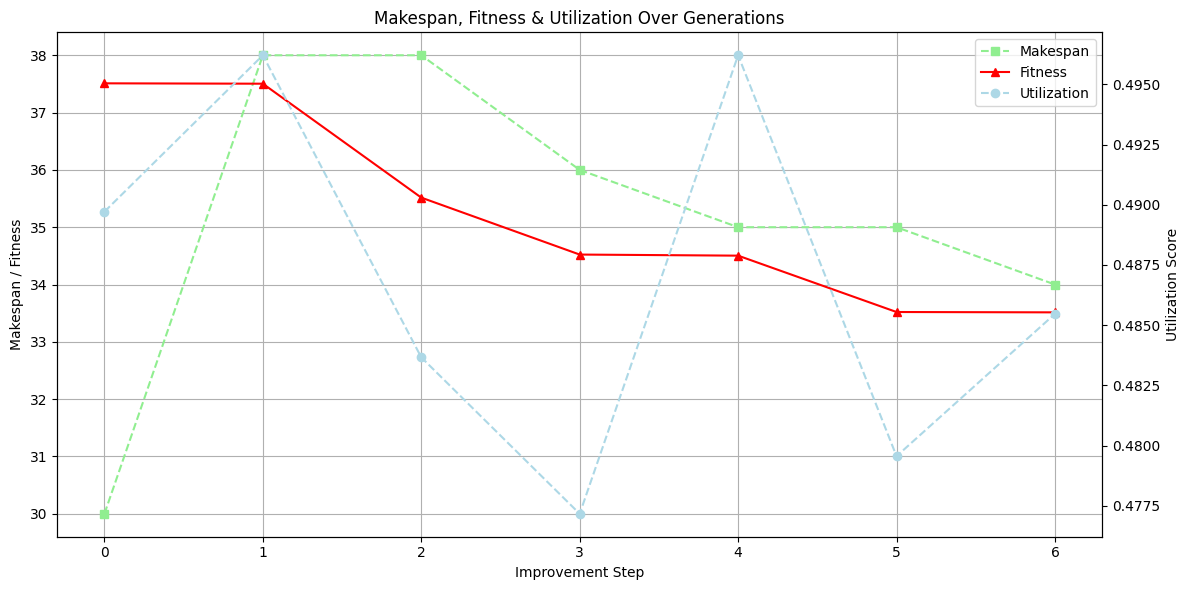

In [29]:
import matplotlib.pyplot as plt

if utilization_scores and makespanss and fitnesses:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Primary y-axis
    ax1.plot(makespanss, marker='s', linestyle='--', color='lightgreen', label='Makespan')
    ax1.plot(fitnesses, marker='^', linestyle='-', color='red', label='Fitness')
    ax1.set_xlabel("Improvement Step")
    ax1.set_ylabel("Makespan / Fitness")
    ax1.grid(True)

    # Secondary y-axis for Utilization
    ax2 = ax1.twinx()
    ax2.plot(utilization_scores, marker='o', linestyle='--', color='lightblue', label='Utilization')
    ax2.set_ylabel("Utilization Score")

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title("Makespan, Fitness & Utilization Over Generations")
    plt.tight_layout()
    plt.show()
